# UNET SEGMENTATION

## 1.1 Architecture

<img src="images/u-net-architecture.png"/>


## 1.2 Code

In [32]:
import os
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras
from models.unet import UNet
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from keras import backend as K

seed = 2024
random.seed = seed
np.random.seed = seed
tf.seed = seed


## Data 

In [24]:
csv_file = pd.read_csv("C:\\Users\\Vlad\\Documents\\airbus-ship-detection\\train_ship_segmentations_v2.csv")


## Data Generator

In [25]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, data, path, csv_file, batch_size=8, image_size=768):
        self.data = data
        self.path = path
        self.csv_file = csv_file
        self.batch_size = batch_size
        self.image_size = image_size
        self.on_epoch_end()

    def __getitem__(self, index):
        if (index + 1) * self.batch_size > len(self.data):
            self.batch_size = len(self.data) - index*self.batch_size
        
        files_batch = self.data[index*self.batch_size : (index+1)*self.batch_size]
        
        x = []
        y = []

        
        for name in files_batch:
            image_path = str(self.path + "\\"+ name)

            img = cv2.imread(image_path)
            img = cv2.resize(img, (self.image_size, self.image_size))
            img = img / 255.0 

            all_masks = self.csv_file[self.csv_file['ImageId'] == name].EncodedPixels
            mask = np.zeros((self.image_size, self.image_size))

            for encoded_pixels_mask in all_masks:
                decoded_mask = rle_decode(encoded_pixels_mask)
                mask = mask + cv2.resize(decoded_mask, (self.image_size, self.image_size))


            mask = mask.astype(np.float32)

            x.append(img)
            y.append(mask)

        return np.array(x), np.array(y)
    
    def on_epoch_end(self):
        pass
    
    def __len__(self):
        return int(np.ceil(len(self.data) / float(self.batch_size)))


## Decoder

In [26]:
def rle_decode(mask_rle, shape=(768, 768)):
    if not mask_rle or pd.isna(mask_rle):
        return np.zeros(shape, dtype=np.uint8)

    s = list(map(int, mask_rle.split()))

    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)

    starts, lengths = s[0::2], s[1::2]
    for start, length in zip(starts, lengths):
        img[start:start + length] = 1

    return img.reshape(shape).T


## Hyperparameters

In [27]:
image_size = 768
train_path = "C:\\Users\\Vlad\\Documents\\airbus-ship-detection\\train_v2"
epochs = 5
batch_size = 4

## Training Ids
train_ids = next(os.walk(train_path))[2]

## Validation Data Size
val_data_size = 10

valid_ids = train_ids[:val_data_size]
train_ids = train_ids[val_data_size:]

In [28]:
gen = DataGenerator(train_ids, train_path,csv_file, batch_size=batch_size, image_size=image_size)
x, y = gen.__getitem__(0)
print(x.shape, y.shape)

(4, 768, 768, 3) (4, 768, 768)


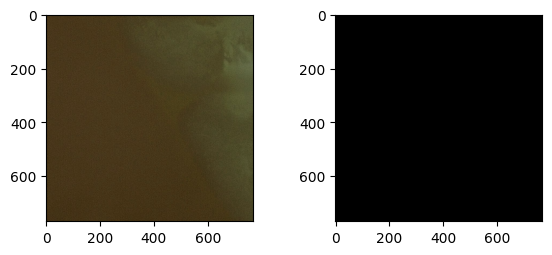

In [29]:
r = random.randint(0, len(x)-1)

fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(1, 2, 1)
ax.imshow(x[r])
ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(y[r], (image_size, image_size)), cmap="gray")

## Different Convolutional Blocks

In [30]:
def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    p = keras.layers.MaxPool2D((2, 2), (2, 2))(c)
    return c, p

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    us = keras.layers.UpSampling2D((2, 2))(x)
    concat = keras.layers.Concatenate()([us, skip])
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

## Dice coeifficent

In [ ]:
def dice_coefficient(y_true, y_pred, smooth=1e-5):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    return (2. * intersection + smooth) / (K.sum(K.square(y_true), -1) + K.sum(K.square(y_pred), -1) + smooth)


## UNet Model

In [33]:
def UNet(image_size):
    f = [16, 32, 64, 128, 256]
    inputs = keras.layers.Input((image_size, image_size, 3))
    
    p0 = inputs
    c1, p1 = down_block(p0, f[0]) #128 -> 64
    c2, p2 = down_block(p1, f[1]) #64 -> 32
    c3, p3 = down_block(p2, f[2]) #32 -> 16
    c4, p4 = down_block(p3, f[3]) #16->8
    
    bn = bottleneck(p4, f[4])
    
    u1 = up_block(bn, c4, f[3]) #8 -> 16
    u2 = up_block(u1, c3, f[2]) #16 -> 32
    u3 = up_block(u2, c2, f[1]) #32 -> 64
    u4 = up_block(u3, c1, f[0]) #64 -> 128
    
    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u4)
    model = keras.models.Model(inputs, outputs, name="Unet")
    return model

In [34]:
model = UNet(image_size)

metrics=["accuracy", dice_coefficient]

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
loss=tf.losses.binary_crossentropy

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
model.summary()

Model: "Unet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 768, 768, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 768, 768, 16)         448       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 768, 768, 16)         2320      ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 384, 384, 16)         0         ['conv2d_1[0][0]']            
 D)                                                                                            

## Training the model

In [ ]:
train_gen = DataGenerator(train_ids, train_path, csv_file, image_size=image_size, batch_size=batch_size)
valid_gen = DataGenerator(valid_ids, train_path, csv_file, image_size=image_size, batch_size=batch_size)

train_steps = len(train_ids) // batch_size
valid_steps = len(valid_ids) // batch_size

model.fit(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps, validation_steps=valid_steps, 
                    epochs=epochs)

Epoch 1/5
   76/29355 [..............................] - ETA: 109:45:35 - loss: 0.1920 - accuracy: 0.9991 - dice_coefficient: 0.4907

## Testing the model

In [ ]:
test_path = 'C:\\Users\\Vlad\\Documents\\airbus-ship-detection\\test_v2'

img_path = os.path.join(test_path, os.listdir(test_path)[8])

def preprocess_input(image_path, target_size=(768, 768)):
    image = cv2.imread(image_path)

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, target_size)
    image = image / 255.0 
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    return image

result = model.predict(preprocess_input(img_path), verbose=0)
result=(result > 0.3).astype(float)

fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
plt.imshow(np.squeeze(preprocess_input(img_path), axis=0));


ax = fig.add_subplot(1, 2, 2)
plt.imshow(np.squeeze(result, axis=0));
plt.show()